In [1]:
import numpy as np
import scipy
import scipy.stats
import scipy.io
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline 
plt.rcParams['figure.figsize'] = [10, 5]
from ipywidgets import interact
import ipywidgets as widgets
import seaborn as sns
from scipy.io import loadmat
import ot
from scipy.ndimage import gaussian_filter1d
from tqdm import tqdm

In [2]:
def load_spikes(path):
    spikes = []
    spikes_mat = loadmat(path)['spike_times'][0]
    for cell_spikes in spikes_mat:
        spikes.append(list(cell_spikes.ravel()))
    return spikes

def load_position(path):
    x_mat,t_mat = loadmat(path)['position'][0][0]
    return x_mat.ravel(),t_mat.ravel()
        
def bin_spikes(spikes, times):
    spike_counts = []
    for cell in range(len(spikes)):
        spike_counts.append(np.histogram(spikes[cell], bins=times)[0])
    return np.asarray(spike_counts)



In [12]:
# import data
path = '/Users/davide/Dropbox/Projects/sleep/SleepData_Matteo/Linear_track/AH1/Track8/'
x,times = load_position(path+'position.mat')
#spikes = #loadmat(path+'spike_times_A1_S8.mat')['spike_times'][0]
spikes = load_spikes(path+'spike_times_A1_S8.mat') 
X = bin_spikes(spikes,times)

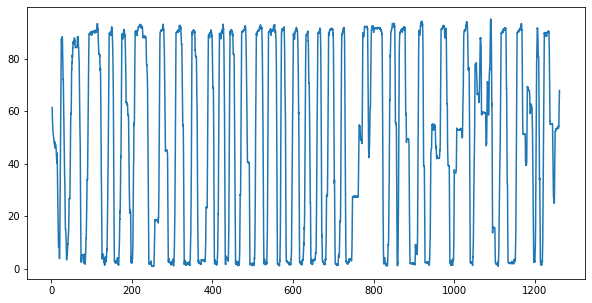

In [13]:
plt.plot(times,x)

In [14]:
# compute ratemaps
from scipy.stats import binned_statistic
space_bins = np.linspace(min(x),max(x),40)
occupancy = np.histogram(x,bins=space_bins)[0]
occupancy[np.where(occupancy==0)] = pow(10,-15)

smooth = True
sigma = 1

firing_rate_maps = []
for i in range(len(spikes)):
    spike_positions = [np.interp(s, times, x) for s in spikes[i]]
    spike_hist = np.histogram(spike_positions, bins=space_bins)[0] 
    ratemap = spike_hist/occupancy
    if smooth:
        ratemap = gaussian_filter1d(ratemap,sigma)
    firing_rate_maps.append(ratemap)
firing_rate_maps = np.asarray(firing_rate_maps)

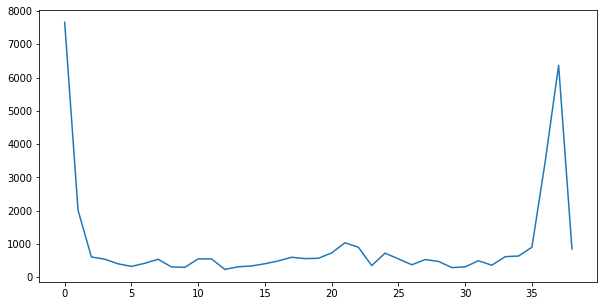

In [15]:
plt.plot(occupancy)

Text(0, 0.5, 'cell #')

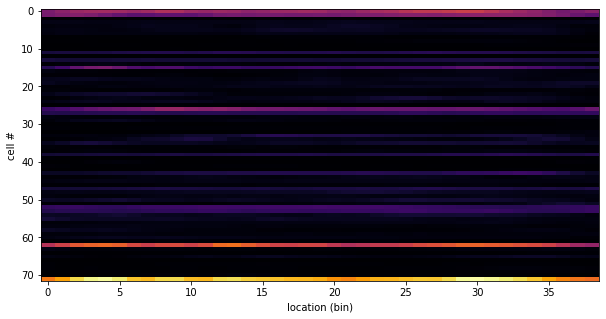

In [16]:
plt.imshow(firing_rate_maps, cmap='inferno',aspect='auto')
plt.xlabel('location (bin)')
plt.ylabel('cell #')

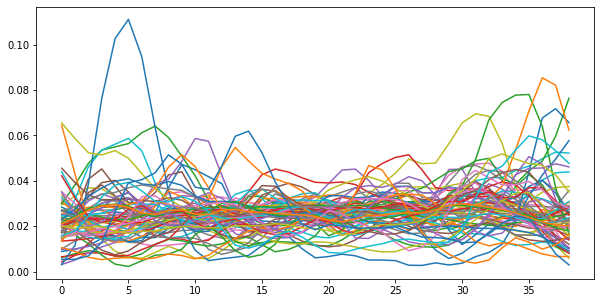

In [17]:
distributions = firing_rate_maps.T/np.sum(firing_rate_maps,axis=-1)

for r in distributions.T:
    plt.plot(r)

In [18]:
# loss matrix + normalization
n_ratemaps_bins = firing_rate_maps.shape[1]
M = ot.utils.dist0(n_ratemaps_bins)
M /= M.max()


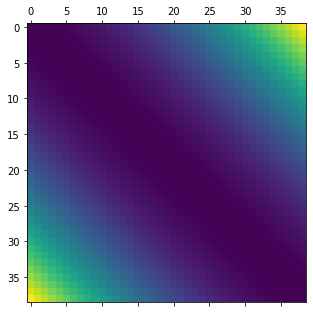

In [19]:
plt.matshow(M)

In [20]:
time_point = 550
Xt = X[:,time_point]
active_idxs = np.where(Xt>0)
ratemaps_t = firing_rate_maps[active_idxs]
distributions = ratemaps_t.T/np.sum(ratemaps_t,axis=-1)
weights = Xt[active_idxs]
weights = weights/sum(weights)

# wasserstein
reg = 1e-3
posterior = ot.bregman.barycenter(distributions, M, reg, weights)



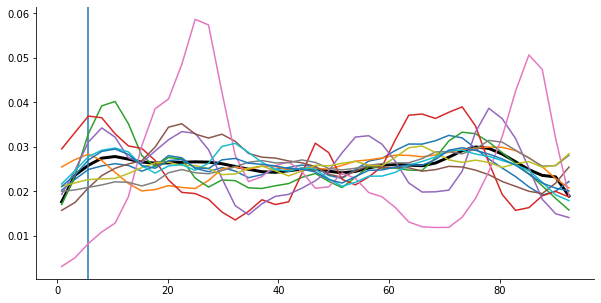

In [21]:
plt.plot(space_bins[:-1],posterior,c='k',linewidth=3)
plt.axvline(x=x[time_point])
for i in range(distributions.shape[-1]):
    plt.plot(space_bins[:-1],distributions[:,i])

sns.despine()

In [22]:
end_time = 10000
occupancy_dist = occupancy/sum(occupancy)
posteriors = []
decoded_x = []
expected_spikes = np.mean(X,axis=1)
for time_point in tqdm(range(end_time)):
    Xt = X[:,time_point]
    active_idxs = np.where(Xt>0)
    ratemaps_t = firing_rate_maps[active_idxs]
    distributions = ratemaps_t.T/np.sum(ratemaps_t,axis=-1)
    weights = Xt[active_idxs]/expected_spikes[active_idxs]
    weights = weights/sum(weights)

    # wasserstein
    reg = 1e-2
    neuron_posterior = ot.bregman.barycenter(distributions, M, reg, weights)
    posterior = neuron_posterior#*occupancy_dist
    posteriors.append(posterior)
    decoded_x.append(space_bins[:-1][np.argmax(posterior)])



 22%|██▏       | 2219/10000 [00:08<00:29, 260.19it/s]/Users/davide/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/davide/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/Users/davide/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/davide/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/davide/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/Users/davide/opt/anaconda3/lib/py

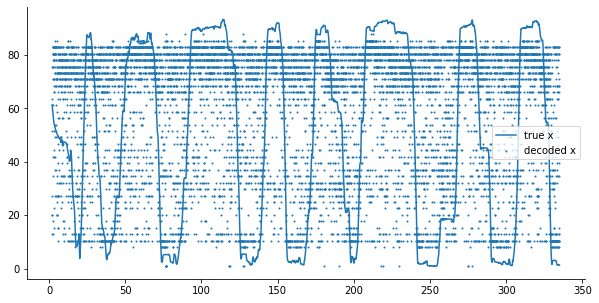

In [24]:
true_x = x[:end_time]
plt.plot(times[:end_time],true_x,label='true x')
plt.scatter(times[:end_time],decoded_x,label='decoded x',s=1)
ot_errors = abs(x[:end_time]-decoded_x)
plt.legend()
sns.despine()

# NAIVE BAYES

In [25]:
def predict_posterior(X,ratemaps, occupancy,epsilon=pow(10, -15)):
        log_posteriors = X @ np.log(ratemaps+epsilon) - np.sum(ratemaps, axis=0) +np.log(occupancy)
        posteriors = np.exp(log_posteriors)
        return posteriors


In [26]:
distributions = firing_rate_maps.T/np.sum(firing_rate_maps,axis=-1)
occupancy_dist = occupancy/sum(occupancy)
NB_posteriors = predict_posterior(X[:,:end_time].T,distributions.T,occupancy_dist)
NB_pred_x = [space_bins[:-1][np.argmax(NB_posterior)] for NB_posterior in NB_posteriors]

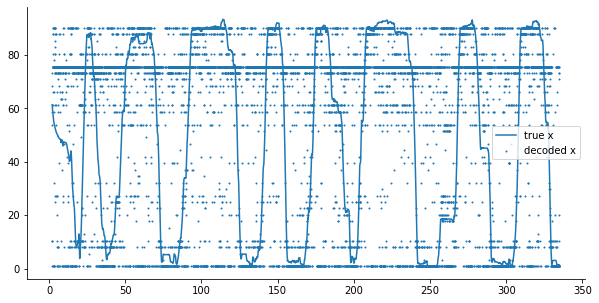

In [27]:
true_x = x[:end_time]
plt.plot(times[:end_time],true_x,label='true x')
plt.scatter(times[:end_time],NB_pred_x,label='decoded x',s=1)
nb_errors = abs(x[:end_time]-NB_pred_x)
plt.legend()
sns.despine()

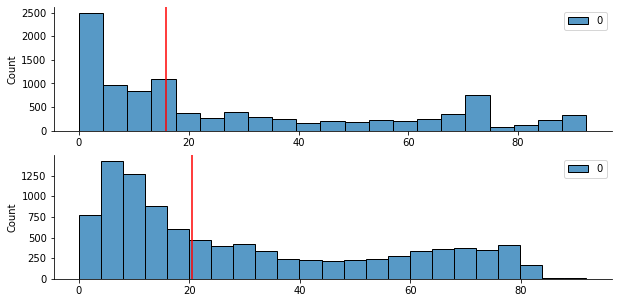

In [28]:
plt.subplot(2,1,1)
sns.histplot(data=[nb_errors])
plt.axvline(x=np.median(nb_errors),c='r')

plt.subplot(2,1,2)
sns.histplot(data=[ot_errors])
plt.axvline(x=np.median(ot_errors),c='r')

sns.despine()


In [29]:
# only during speed >0
speed = np.diff(x[:end_time])
speed_idxs = np.where(abs(speed)>0.3)

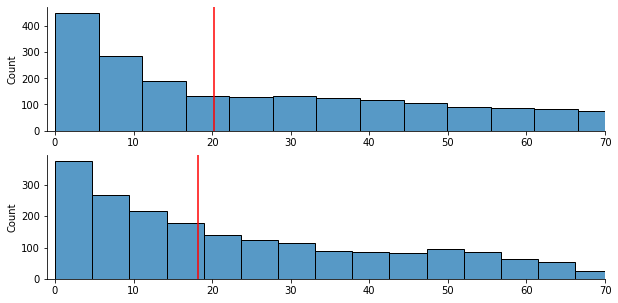

In [30]:
plt.subplot(2,1,1)
filtered_nb_err = nb_errors[:-1][speed_idxs]
sns.histplot(data=filtered_nb_err)
plt.axvline(x=np.median(filtered_nb_err),c='r')
plt.xlim([-1,70])
plt.subplot(2,1,2)
filtered_ot_err = ot_errors[:-1][speed_idxs]
sns.histplot(data=filtered_ot_err)
plt.axvline(x=np.median(filtered_ot_err),c='r')
plt.xlim([-1,70])

sns.despine()

In [ ]:
# With sliding window